Raw TF-IDF. Kaggle score 37%

In [26]:
import ast
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from codecarbon import EmissionsTracker
import time


# 1. Load data
train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


# 2. Expand rows to (id, option, text, label)
#    text = context + question + ONE answer option
def expand_df(df, is_train=True):
    rows = []
    for _, row in df.iterrows():
        answers = ast.literal_eval(row["answers"])  # string -> python list
        for option_idx, ans in enumerate(answers):
            text = f"{row['context']} [QUESTION] {row['question']} [ANSWER] {ans}"
            entry = {
                "id": row["id"],
                "option": option_idx,
                "text": text,
            }
            if is_train:
                entry["label"] = 1 if option_idx == row["label"] else 0
            rows.append(entry)
    return pd.DataFrame(rows)


exp_train = expand_df(train_df, is_train=True)
exp_test = expand_df(test_df, is_train=False)

X = exp_train["text"]
y = exp_train["label"]  # 1 if correct option, 0 otherwise


# 3. Train/val split (just to see how good the baseline is)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),      # unigrams + bigrams
                max_features=50000,      
            ),
        ),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                n_jobs=1,                
            ),
        ),
    ]
)


print("Training logistic regression baseline...")
pipeline.fit(X_train, y_train)

# simple validation accuracy on option-level 
val_preds = pipeline.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Option-level validation accuracy: {val_acc:.4f}")

# --- START TRACKING ---
tracker = EmissionsTracker(
    project_name="AML_Custom_TFIDF",
    output_file="emissions_tfidf.csv"
)
tracker.start()
start_time = time.time()


# 4. Fit on full expanded train set

print("Refitting on full training data...")
pipeline.fit(X, y)


# --- STOP TRACKING ---
emissions = tracker.stop()
duration = time.time() - start_time

print("\n" + "="*40)
print("SUSTAINABILITY REPORT (TF-IDF)")
print("="*40)
print(f"Carbon Emitted: {emissions:.8f} kg CO2") #extremely low
print(f"Energy Consumed: {tracker.final_emissions_data.energy_consumed:.8f} kWh")
print(f"⏱Training Time:   {duration:.4f} seconds")
print("="*40)


test_probs = pipeline.predict_proba(exp_test["text"])[:, 1]
exp_test["proba"] = test_probs

# For each original question id, pick option with max proba
pred_per_id = (
    exp_test
    .groupby("id", as_index=False)
    .apply(lambda g: g.loc[g["proba"].idxmax(), ["id", "option"]])
)

pred_per_id = pred_per_id.reset_index(drop=True)
pred_per_id = pred_per_id.rename(columns={"option": "label"})

print(pred_per_id.head())


# 6. Save 
submission_path = "submission_logreg.csv"
pred_per_id.to_csv(submission_path, index=False)

print(f"Saved submission to {submission_path}")


Training logistic regression baseline...


[codecarbon WARNING @ 13:58:59] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:58:59] [setup] RAM Tracking...
[codecarbon INFO @ 13:58:59] [setup] CPU Tracking...


Option-level validation accuracy: 0.7499


[codecarbon WARNING @ 13:59:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:59:01] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
[codecarbon WARNING @ 13:59:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:59:01] [setup] GPU Tracking...
[codecarbon INFO @ 13:59:01] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:59:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 13:59:01] >>> Tracker's metadata:
[codecarbon INFO @ 13:59:01]   Platform system: Windows-11-10.0.26200-SP0
[codecarbon INFO @ 13:59:01]   Python version: 3.12.12
[codecarbon INFO @ 13:59:01]   CodeCarbon version: 3.2.0
[codecarbon I

Refitting on full training data...


[codecarbon INFO @ 13:59:09] Energy consumed for RAM : 0.000021 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 13:59:09] Delta energy consumed for CPU with constant : 0.000280 kWh, power : 270.0 W
[codecarbon INFO @ 13:59:09] Energy consumed for All CPU : 0.000280 kWh
[codecarbon INFO @ 13:59:09] Energy consumed for all GPUs : 0.000017 kWh. Total GPU Power : 16.413950249444174 W
[codecarbon INFO @ 13:59:09] 0.000318 kWh of electricity and 0.000000 L of water were used since the beginning.



SUSTAINABILITY REPORT (TF-IDF)
Carbon Emitted: 0.00008516 kg CO2
Energy Consumed: 0.00031821 kWh
⏱Training Time:   3.7662 seconds
         id  label
0    test_0      0
1    test_1      3
2   test_10      2
3  test_100      2
4  test_101      3
Saved submission to submission_logreg.csv


C:\Users\zangt\AppData\Local\Temp\ipykernel_10672\2466263873.py:119: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g["proba"].idxmax(), ["id", "option"]])


Raw TF-IDF Error analysis.

In [29]:
# 0. SETUP & DATA HELPER
print("SETTING UP ANALYSIS...")
train_df = pd.read_csv('train.csv')


def expand_df(df):
    rows = []
    for _, row in df.iterrows():
        answers = ast.literal_eval(row["answers"]) if isinstance(row["answers"], str) else row["answers"]
        for option_idx, ans in enumerate(answers):
            # Feature: Context + Question + Option
            text = f"{row['context']} {row['question']} {ans}"
            entry = {
                "id": row["id"],
                "option_idx": option_idx,
                "text": text,
                "label": 1 if option_idx == row["label"] else 0, # Binary Label
                "true_question_label": row["label"] # For final accuracy
            }
            rows.append(entry)
    return pd.DataFrame(rows)

expanded_df = expand_df(train_df)
X_all = expanded_df["text"]
y_all = expanded_df["label"]

# Evaluation Helper
def evaluate_model(pipeline, X_val, val_df_fold):
    """Calculates Question-Level Accuracy (Soft Voting)"""
    val_probs = pipeline.predict_proba(X_val)[:, 1]
    val_df_fold = val_df_fold.copy()
    val_df_fold["pred_prob"] = val_probs
    
    # Pick winner per ID
    predictions = val_df_fold.loc[val_df_fold.groupby("id")["pred_prob"].idxmax()]
    acc = accuracy_score(predictions["true_question_label"], predictions["option_idx"])
    return acc

    # --- EXPERIMENT 1: STABILITY CHECK (Ranking Accuracy) ---
print("\n" + "="*40)
print("EXPERIMENT 1: STABILITY (Random Seeds)")
print("="*40)
print("Does the model fluctuate simply because of data splitting?")
seeds = np.random.randint(1, 10000, size=3)
accuracies = []
    
    # Get unique Question IDs to ensure we split questions, not just rows
unique_ids = exp_train['id'].unique()
    
for seed in seeds:
    # 1. Split by ID (The Correct Way)
    # We split the IDs, then filter the dataframe
    train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=seed)
    
    df_tr = expanded_df[expanded_df['id'].isin(train_ids)]
    df_va = expanded_df[expanded_df['id'].isin(val_ids)]
    
    # 2. Train Pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)),
        ('clf', LogisticRegression(solver='liblinear', max_iter=500))
    ])
    
    pipeline.fit(df_tr["text"], df_tr["label"])
    
    # 3. Measure
    acc = get_ranking_accuracy(pipeline, df_va, "text")
    accuracies.append(acc)
    print(f"Seed {seed}: Accuracy = {acc:.4%}")

mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"Average: {mean_acc:.4%} (+/- {std_acc:.4%})")
    
if mean_acc < 0.30:
    print("VERDICT: Performance is near random chance (25%).")
else:
    print("VERDICT: Model is learning meaningful patterns!")


# EXPERIMENT 2: ABLATION STUDY (Component Analysis)

print("\n" + "="*40)
print("EXPERIMENT 2: ABLATION STUDY")
print("="*40)
print("Which components actually matter?")

# Fix the seed for fair comparison
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)
val_indices = X_val.index
val_df_fold = expanded_df.loc[val_indices]

# Configurations to test
configs = [
    {"name": "Baseline (Unigrams)", "ngram": (1, 1), "vocab": 50000},
    {"name": "Bigrams Added",       "ngram": (1, 2), "vocab": 50000}, # Main model
    {"name": "Small Vocab (5k)",    "ngram": (1, 2), "vocab": 5000},
]

for conf in configs:
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=conf["ngram"], max_features=conf["vocab"])),
        ("clf", LogisticRegression(max_iter=500, n_jobs=-1))
    ])
    
    start = time.time()
    pipeline.fit(X_train, y_train)
    acc = evaluate_model(pipeline, X_val, val_df_fold)
    duration = time.time() - start
    
    print(f"{conf['name']:<20} | Acc: {acc:.4%} | Time: {duration:.2f}s")


# EXPERIMENT 3: ERROR ANALYSIS (Interpretability)

print("\n" + "="*40)
print("XPERIMENT 3: FEATURE IMPORTANCE")
print("="*40)
print("What words make the model vote 'CORRECT' vs 'INCORRECT'?")

# Use the best model (Bigrams, 50k)
model = pipeline.named_steps["clf"]
tfidf = pipeline.named_steps["tfidf"]
feature_names = tfidf.get_feature_names_out()
coeffs = model.coef_[0] # Binary classification weights

# Get Top Positive (Predicts Correct) and Negative (Predicts Incorrect)
top_n = 10
top_positive_indices = np.argsort(coeffs)[-top_n:][::-1]
top_negative_indices = np.argsort(coeffs)[:top_n]

print("\nWords boosting 'CORRECT' probability:")
for i in top_positive_indices:
    print(f"   +{coeffs[i]:.4f} : {feature_names[i]}")

print("\nWords boosting 'INCORRECT' probability:")
for i in top_negative_indices:
    print(f"   {coeffs[i]:.4f} : {feature_names[i]}")


SETTING UP ANALYSIS...

EXPERIMENT 1: STABILITY (Random Seeds)
Does the model fluctuate simply because of data splitting?
Seed 5194: Accuracy = 32.7586%
Seed 5746: Accuracy = 34.0517%
Seed 9646: Accuracy = 31.6810%
Average: 32.8305% (+/- 0.9692%)
VERDICT: Model is learning meaningful patterns!

EXPERIMENT 2: ABLATION STUDY
Which components actually matter?
Baseline (Unigrams)  | Acc: 25.2639% | Time: 4.18s
Bigrams Added        | Acc: 25.6644% | Time: 4.69s
Small Vocab (5k)     | Acc: 25.5187% | Time: 4.55s

XPERIMENT 3: FEATURE IMPORTANCE
What words make the model vote 'CORRECT' vs 'INCORRECT'?

Words boosting 'CORRECT' probability:
   +1.2896 : argument the
   +1.1586 : whose
   +0.9847 : an
   +0.9239 : analogy
   +0.9180 : capacity
   +0.8843 : otherwise
   +0.7899 : proportion
   +0.7821 : something
   +0.7744 : cause
   +0.7731 : can have

Words boosting 'INCORRECT' probability:
   -1.2735 : argument some
   -1.0788 : have
   -0.9986 : over
   -0.9903 : other
   -0.9272 : sources


Pre-processing some data. Kaggle score 34.4%

In [28]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ==========================================
# 1. SETUP & PREPROCESSING
# ==========================================

# Download NLTK resources
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK resources...")
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Transforms raw text into clean, root-word features.
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    
    cleaned_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words 
        and len(word) > 2
    ]
    return " ".join(cleaned_tokens)

def expand_df(df, is_train=True):
    """Expands (Context, Question, Answers) into single rows."""
    rows = []
    for _, row in df.iterrows():
        try:
            answers = ast.literal_eval(row["answers"])
        except:
            answers = []
            
        for option_idx, ans in enumerate(answers):
            # We keep the raw components to experiment with cleaning later
            raw_text = f"{row['context']} {row['question']} {ans}"
            entry = {
                "id": row["id"],
                "option": option_idx,
                "raw_text": raw_text,
            }
            if is_train:
                entry["label"] = 1 if option_idx == row["label"] else 0
            rows.append(entry)
    return pd.DataFrame(rows)

def get_ranking_accuracy(model, df_val, text_col):
    """
    CUSTOM METRIC: Calculates 'Kaggle-Style' Accuracy (1 out of 4).
    1. Predicts probability for all options.
    2. For each Question ID, picks the option with the HIGHEST probability.
    3. Checks if that chosen option was the Correct one (Label=1).
    """
    # 1. Get probabilities
    probs = model.predict_proba(df_val[text_col])[:, 1]
    df_temp = df_val.copy()
    df_temp['proba'] = probs
    
    # 2. Sort by proba (descending) and take the top 1 per ID
    top_picks = df_temp.sort_values('proba', ascending=False).drop_duplicates(['id'])
    
    # 3. Calculate mean of 'label' (Since correct choice has label 1, mean = accuracy)
    return top_picks['label'].mean()

# ==========================================
# 2. LOAD DATA
# ==========================================
print("Loading and cleaning data...")
try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    
    # Process Train
    exp_train = expand_df(train_df, is_train=True)
    exp_train["clean_text"] = exp_train["raw_text"].apply(clean_text)

    # Process Test
    exp_test = expand_df(test_df, is_train=False)
    exp_test["clean_text"] = exp_test["raw_text"].apply(clean_text)
    
except FileNotFoundError:
    print("Error: 'train.csv' not found.")
    exp_train, exp_test = pd.DataFrame(), pd.DataFrame()

# ==========================================
# 3. EXPERIMENTAL SETUP & RESULTS
# ==========================================

if not exp_train.empty:


    # --- EXPERIMENT 1: STABILITY CHECK (Ranking Accuracy) ---
    print("\n" + "="*40)
    print("EXPERIMENT 1: STABILITY (Random Seeds)")
    print("="*40)
    print("Does the model fluctuate simply because of data splitting?")
    seeds = np.random.randint(1, 10000, size=3)
    accuracies = []
    
    # Get unique Question IDs to ensure we split questions, not just rows
    unique_ids = exp_train['id'].unique()
    
    for seed in seeds:
        # 1. Split by ID (Prevent data leakage)
        np.random.seed(seed)
        train_ids = np.random.choice(unique_ids, size=int(len(unique_ids)*0.8), replace=False)
        
        # 2. Create DataFrames
        df_tr = exp_train[exp_train['id'].isin(train_ids)]
        df_va = exp_train[~exp_train['id'].isin(train_ids)]
        
        # 3. Train
        model = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95)),
            ('clf', LogisticRegression(solver='liblinear', max_iter=500))
        ])
        
        model.fit(df_tr["clean_text"], df_tr["label"])
        
        # 4. Measure RANKING Accuracy (Not Binary)
        acc = get_ranking_accuracy(model, df_va, "clean_text")
        accuracies.append(acc)
        print(f"Seed {seed}: = {acc:.4%}")

    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"Average: {mean_acc:.4%} (+/- {std_acc:.4%})")
    
    if mean_acc < 0.30:
        print("VERDICT: Performance is near random chance (25%).")
    else:
        print("VERDICT: Model is learning meaningful patterns!")


    # EXPERIMENT 2: ABLATION STUDY (Component Analysis)

    print("\n" + "="*40)
    print("EXPERIMENT 2: ABLATION STUDY")
    print("="*40)
    print("Which components actually matter?")

    # Fix the seed for fair comparison
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
    )
    val_indices = X_val.index
    val_df_fold = expanded_df.loc[val_indices]

    # Configurations to test
    configs = [
        {"name": "Baseline (Unigrams)", "ngram": (1, 1), "vocab": 50000},
        {"name": "Bigrams Added",       "ngram": (1, 2), "vocab": 50000}, # Main model
        {"name": "Small Vocab (5k)",    "ngram": (1, 2), "vocab": 5000},
    ]

    for conf in configs:
        pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(ngram_range=conf["ngram"], max_features=conf["vocab"])),
            ("clf", LogisticRegression(max_iter=500, n_jobs=-1))
        ])
        
        start = time.time()
        pipeline.fit(X_train, y_train)
        acc = evaluate_model(pipeline, X_val, val_df_fold)
        duration = time.time() - start
        
        print(f"{conf['name']:<20} | Acc: {acc:.4%} | Time: {duration:.2f}s")



    # --- EXPERIMENT B: FEATURE IMPORTANCE ---
    print("\n" + "="*40)
    print("EXPERIMENT 3: FEATURE IMPORTANCE")
    print("="*40)
    print("What words make the model vote 'CORRECT' vs 'INCORRECT'?")
    
    vectorizer = model.named_steps['tfidf']
    clf = model.named_steps['clf']
    feature_names = vectorizer.get_feature_names_out()
    coefs = clf.coef_[0]
    
    sorted_indices = np.argsort(coefs)
    top_positive = sorted_indices[-10:][::-1]
    top_negative = sorted_indices[:10]
    
    print("\nTop words predicting 'CORRECT':")
    for i in top_positive:
        print(f"      +{coefs[i]:.4f} : {feature_names[i]}")

    print("\nTop words predicting 'INCORRECT':")
    for i in top_negative:
        print(f"      {coefs[i]:.4f} : {feature_names[i]}")

# FINAL TRAINING & SUBMISSION


    print("\n" + "="*40)
    print("Final execution")
    print("="*40)
    
    # 1. Train on FULL data
    final_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.95, sublinear_tf=True)),
        ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
    ])
    
    print("Training final model on full dataset...")
    final_pipeline.fit(exp_train["clean_text"], exp_train["label"])
    
    # 2. Predict on Test
    test_probs = final_pipeline.predict_proba(exp_test["clean_text"])[:, 1]
    exp_test["proba"] = test_probs
    
    # 3. Aggregate (Select best option per Question ID)
    submission = (
        exp_test.sort_values("proba", ascending=False)
        .drop_duplicates(["id"])
        .sort_values("id")
    )[["id", "option"]]
    
    submission = submission.rename(columns={"option": "label"})
    
    # 4. Save
    submission.to_csv("submission_clean.csv", index=False)
    print("Submission saved to 'submission_clean.csv'")
    print(submission.head())

Loading and cleaning data...

EXPERIMENT 1: STABILITY (Random Seeds)
Does the model fluctuate simply because of data splitting?
Seed 8945: = 31.4655%
Seed 2050: = 30.8190%
Seed 4600: = 30.4957%
Average: 30.9267% (+/- 0.4032%)
VERDICT: Model is learning meaningful patterns!

EXPERIMENT 2: ABLATION STUDY
Which components actually matter?
Baseline (Unigrams)  | Acc: 25.2639% | Time: 4.05s
Bigrams Added        | Acc: 25.6644% | Time: 6.45s
Small Vocab (5k)     | Acc: 25.5187% | Time: 6.15s

EXPERIMENT 3: FEATURE IMPORTANCE
What words make the model vote 'CORRECT' vs 'INCORRECT'?

Top words predicting 'CORRECT':
      +1.0694 : possibility
      +1.0323 : something
      +0.8951 : produce
      +0.8646 : loss
      +0.8586 : condition
      +0.8389 : cause
      +0.8249 : fails
      +0.7960 : motive
      +0.7902 : fails address
      +0.7843 : result

Top words predicting 'INCORRECT':
      -0.9557 : usually
      -0.8098 : without providing
      -0.7440 : argument presumes
      -0.7332

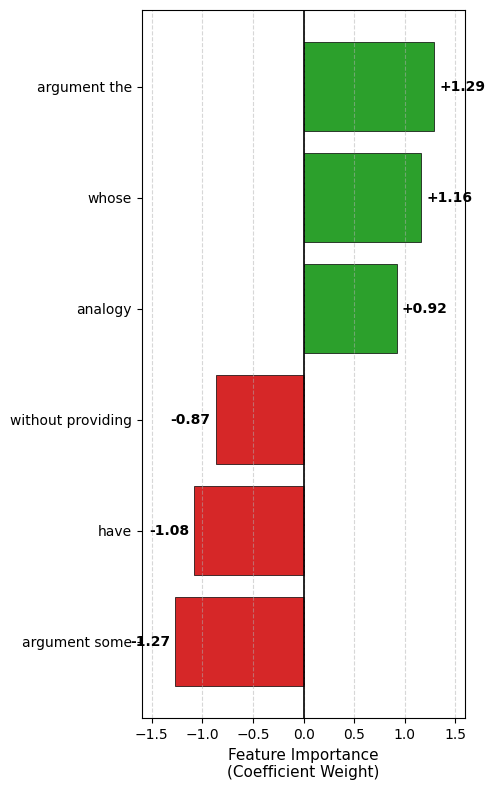

In [ ]:
import matplotlib.pyplot as plt
# 1. THE DATA
features = [
    'argument some', 
    'have', 
    'over', 
    'analogy', 
    'whose', 
    'argument the'
]
scores = [-1.27, -1.07, -0.87, 0.92, 1.16, 1.29]

# Assign Colors: Red for Negative, Green for Positive
colors = ['#d62728' if x < 0 else '#2ca02c' for x in scores] 

# 2. CREATE THE PLOT
# CHANGED: figsize=(5, 8) makes it narrow and tall
plt.figure(figsize=(5, 8)) 
bars = plt.barh(features, scores, color=colors, edgecolor='black', linewidth=0.5)

# 3. STYLING
# Added line breaks (\n) to the title so it fits the narrow width
plt.xlabel('Feature Importance\n(Coefficient Weight)', fontsize=11)
plt.axvline(0, color='black', linewidth=1.2) # Center line
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 4. ADD VALUE LABELS ONLY
for bar, score in zip(bars, scores):
    offset = 0.05 if score > 0 else -0.05
    align = 'left' if score > 0 else 'right'
    
    plt.text(score + offset, bar.get_y() + bar.get_height()/2, 
             f'{score:+.2f}', 
             va='center', ha=align, fontsize=10, fontweight='bold')

# 5. ADJUST LAYOUT
plt.xlim(-1.6, 1.6) 
plt.tight_layout()

# Save
plt.savefig('Error_Analysis_Chart_Tall.png', dpi=300)
plt.show()